In [24]:
import torch
import pathlib
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from segmentation_models_pytorch import Unet

def preprocess_image_for_inference(image_path, normalize=False, mean=None, std=None):
    # Lee la imagen
    image = np.load(image_path).squeeze()
    # image = image.transpose("y", "x", "band").astype(float).values
    image = np.moveaxis(image, 0, -1)

    # Define la pipeline de preprocesamiento
    preprocess_pipeline = transforms.Compose([
        transforms.ToTensor()  # Convierte la imagen a tensor
    ])

    if normalize and mean is not None and std is not None:
        preprocess_pipeline.transforms.append(transforms.Normalize(mean=mean, std=std))

    # Aplica el preprocesamiento
    image = preprocess_pipeline(image).float()
    image = image.unsqueeze(0)  # Añade la dimensión de batch

    return image

def inference_model(checkpoint_path, normalize, mean, std, path_to_image, threshold):
    # Load the Student model
    model = Unet(encoder_name="mit_b1", in_channels=3, classes=1)
    checkpoint = torch.load(checkpoint_path)
    filter_ckpt = {k: v for k, v in checkpoint.items()}
    model.load_state_dict(filter_ckpt)
    model = model.cuda()
    model.eval()

    # Load the image
    image = preprocess_image_for_inference(path_to_image, normalize=normalize, 
                                           mean=mean, std=std).cuda()
    
    with torch.no_grad():
        output = model(image)
        output = (output > threshold).float() ## Binarize the output

    output = output.cpu().squeeze().numpy()
    return output

def get_vis(folder: str):
    plt.title("S2 SR - 2.5m - Buildings")
    plt.axis("off")
    # sr_filename = f"sr_{date_eval}.png"
    # sr_path = os.path.join(new_folder, sr_filename)
    # plt.savefig(sr_path)
    # plt.close()

In [25]:
image_files = ["../data/out_superimage/00036_1.npy"]
image_file = image_files[0]
checkpoint_path = "../weights/mit_b1unet_best_model.pth"
threshold = 0.5
normalize = True
mean = [0.2108307 , 0.1849077 , 0.15864254]
std = [0.05045007, 0.0406715 , 0.03748639]

out = inference_model(checkpoint_path, normalize, mean, std, image_file, threshold)

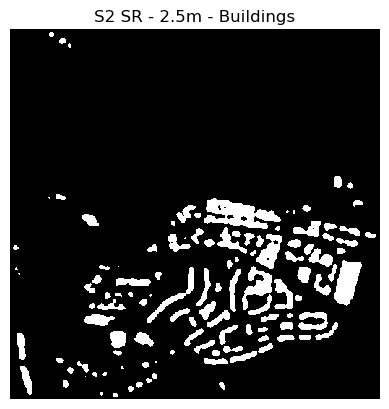

In [21]:
plt.title("S2 SR - 2.5m - Buildings")
plt.axis("off")
plt.imshow(out, cmap="gray", vmin=0, vmax=1, interpolation="none")